# Decision Tree Lab

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.io import arff
from sklearn import tree
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os

In [4]:
class node:
    def __init__(self, x, y, mom=None, type='split', info=0, split_index=None, predicted_out_class=-1):
        self.x = x
        self.y = y
        self.kids = []
        self.mom = mom
        self.type = type
        self.info = info
        self.split_index = split_index
        self.predicted_out_class = predicted_out_class

In [2]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, feat_maps=None, col_map=None, counts=None):
        self.feat_maps=feat_maps
        self.col_map=col_map
        self.counts = counts
        self.info_gains = []

    def fit(self, x, y):
        self.root = node(x, y, info=self.get_info(y))
        self.split(self.root)

    def split(self, n):
        self.make_kids(n, self.best_split(n))
        for kid in n.kids:
            if kid.type != 'leaf':
                self.split(kid)
        return
                
    def get_info(self, y):
        y_counts = np.unique(y, return_counts=True)[1]
        info = 0
        for i in range(len(y_counts)):
            p = y_counts[i] / len(y)
            if p != 0:
                info += (-p * math.log2(p))
        return info
        
    def calc_row(self, x, y):
        row_info = 0
        x_values, x_counts = np.unique(x, return_counts=True)
        xy = pd.DataFrame(np.column_stack((x,y)))
        for i in range(len(x_counts)):
            new_y = np.array(xy[xy.iloc[:,0]==x_values[i]].iloc[:,1])
            coef = x_counts[i] / sum(x_counts)
            row_info += coef * self.get_info(new_y)
        return row_info

    def make_kids(self, n, split):
        n.split_index = split
        feature_column = n.x[:,split]
        unique_feature_values = np.unique(feature_column)
        for i in range(len(unique_feature_values)):
            x, y = self.split_data(n.x, n.y, split, unique_feature_values[i])
            kid = node(x, y, info=self.get_info(y), mom=n)
            n.kids.append(kid)
            y_vals = np.unique(y)
            if len(y_vals) == 1:
                kid.type='leaf'
                kid.predicted_out_class = y_vals[0]

    def split_data(self, x, y, split, val):
        print('Splitting on', split)
        x_values = np.unique(x, return_counts=True)[0]
        xy = pd.DataFrame(np.column_stack((x,y)))
        df = xy[xy.iloc[:,split]==val]
        return np.array(df.iloc[:,0:-1]), np.array(df.iloc[:,-1])

    def best_split(self, n):
        infos = []
        for i in range(n.x.shape[1]):
            infos.append(n.info-self.calc_row(n.x[:,i],n.y))
        self.info_gains.append(infos[np.argmax(infos)])
        return np.argmax(infos)

    def predict(self, x):
        predictions = []
        for i in range(x.shape[0]):
            row = x[i,:]
            currNode = self.root
            while currNode.type != 'leaf':
                split_index = currNode.split_index
                split_value = row[split_index]
                if split_value >= len(currNode.kids):
                    predictions.append(1)
                    break
                currNode = currNode.kids[split_value]
                if currNode.type == 'leaf':
                    predictions.append(currNode.predicted_out_class)
        return predictions

    def score(self, x, y):
        predictions = self.predict(x)
        return sum(predictions == y) / len(y)

In [3]:
def getCounts(df):
    counts = []
    for i in range(len(df.columns)):
        counts.append(len(df[df.columns[i]].value_counts()))
    return counts

def encode_feature(series):
    new_series = series.copy()
    targets = series.unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    new_series = series.replace(map_to_int)
    map = {n: name for n, name in enumerate(targets)}
    return new_series, map

def encode_df(df):
    new_df = df.copy()
    maps = {}
    for i in list(df.columns):
        new_df[i], map = encode_feature(df[i])
        maps[i] = map
    col_map = {}
    for i in enumerate(df.columns):
        col_map[i[0]] = i[1]
    return new_df, maps, col_map

## Debug

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [5]:
# Load debug training data
debug_train = pd.DataFrame(arff.loadarff('datasets/lenses.arff')[0])
debug_train = debug_train.apply(lambda x: x.str.decode('utf8'))
debug_train_encoded, debug_train_maps, debug_train_col_map = encode_df(debug_train)
debug_train_x = np.array(debug_train_encoded.iloc[:, 0:-1])
debug_train_y = np.array(debug_train_encoded.iloc[:, -1])

# Train Decision Tree
debug_DT = DTClassifier(debug_train_maps, debug_train_col_map, counts = getCounts(debug_train_encoded.iloc[:, 0:-1]))
debug_DT.fit(debug_train_x, debug_train_y)

# Load debug test data
debug_test = pd.DataFrame(arff.loadarff('datasets/lenses_test.arff')[0])
debug_test = debug_test.apply(lambda x: x.str.decode('utf8'))
debug_test_encoded, debug_test_maps, debug_test_col_map = encode_df(debug_test)
debug_test_x = np.array(debug_test_encoded.iloc[:, 0:-1])
debug_test_y = np.array(debug_test_encoded.iloc[:, -1])

# Predict and compute model accuracy
print("Score:", debug_DT.score(debug_test_x, debug_test_y))

# Print the information gain of every split you make.
print('Info Gains:',debug_DT.info_gains)

Splitting on 3
Splitting on 3
Splitting on 2
Splitting on 2
Splitting on 0
Splitting on 0
Splitting on 0
Splitting on 1
Splitting on 1
Splitting on 1
Splitting on 1
Splitting on 0
Splitting on 0
Splitting on 0
Score: 0.3333333333333333
Info Gains: [0.5487949406953985, 0.7704260414863778, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]


In [6]:
pizza = pd.DataFrame(data=np.array([['Y','Thin','N','Great'],
                                    ['N','Deep','N','Bad'],
                                    ['N','Stuffed','Y','Good'],
                                    ['Y','Stuffed','Y','Great'],
                                    ['Y','Deep','N','Good'],
                                    ['Y','Deep','Y','Great'],
                                    ['N','Thin','Y','Good'],
                                    ['Y','Deep','N','Good'],
                                    ['N','Thin','N','Bad']]),
                                    columns=['Meat','Crust','Veg','Quality'])

pizza_encoded, pizza_maps, pizza_col_map = encode_df(pizza)
# pizza_x = np.array(pizza_encoded.iloc[:,0:-1])
# pizza_y = np.array(pizza_encoded.iloc[:,-1])

pizza_x = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
pizza_y = np.array([2,0,1,2,1,2,1,1,0])

pizza_df = pd.DataFrame(np.column_stack((pizza_x,pizza_y)), columns=['Meat','Crust','Veg','Quality'])

pizza_DT = DTClassifier(counts=[2,3,2], col_map=pizza_col_map)
pizza_DT.fit(pizza_x, pizza_y)

print('Info Gains:',pizza_DT.info_gains)

Splitting on 0
Splitting on 0
Splitting on 2
Splitting on 2
Splitting on 1
Splitting on 1
Splitting on 1
Splitting on 2
Splitting on 2
Info Gains: [0.5466316153937778, 1.0, 0.4199730940219749, 0.9182958340544896]


## Zoo Dataset

In [223]:
# Load zoo training data
zoo_train = pd.DataFrame(arff.loadarff('datasets/zoo.arff')[0])
zoo_train = zoo_train.apply(lambda x: x.str.decode('utf8'))
zoo_train_encoded, zoo_train_maps, zoo_train_col_map = encode_df(zoo_train)
zoo_train_x = np.array(zoo_train_encoded.iloc[:, 0:-1])
zoo_train_y = np.array(zoo_train_encoded.iloc[:, -1])

# Train Decision Tree
zoo_DT = DTClassifier(zoo_train_maps, zoo_train_col_map, counts = getCounts(zoo_train_encoded.iloc[:, 0:-1]))
zoo_DT.fit(zoo_train_x, zoo_train_y)

# Load zoo test data
zoo_test = pd.DataFrame(arff.loadarff('datasets/zoo_test.arff')[0])
zoo_test = zoo_test.apply(lambda x: x.str.decode('utf8'))
zoo_test_encoded, zoo_test_maps, zoo_test_col_map = encode_df(zoo_test)
zoo_test_x = np.array(zoo_test_encoded.iloc[:, 0:-1])
zoo_test_y = np.array(zoo_test_encoded.iloc[:, -1])

# Predict and compute model accuracy
print("Score:", zoo_DT.score(zoo_test_x, zoo_test_y))

# Print the information gain of every split you make.
print('Info Gains:',zoo_DT.info_gains)

Score: 0.145
Info Gains: [1.3630469031539394, 0.6892019851173656, 0.8631205685666308, 0.7219280948873623, 0.8865408928220899, 0.9852281360342515, 0.6962122601251458, 0.8256265261578954, 0.7219280948873623]


## 10-fold Cross Validation

In [224]:
# Write a function that implements 10-fold cross validation
def fit_num_fold(x, y, num, counts):
    x, y = shuffle(x, y)
    train_scores = []
    test_scores = []
    xy = np.column_stack((x,y))
    test_row_size = math.floor(len(x) / num)
    xy_extra, xy_data = cutoff_extra(xy, num)
    for i in range(num):
        i1 = (i * test_row_size)
        i2 = (i1 + test_row_size)
        train1, test, train2 = np.split(ary=xy_data, indices_or_sections=[i1, i2], axis=0)
        train = np.vstack((xy_extra, train1, train2))
        train_x, train_y = train[:,0:-1], train[:,-1]
        test_x, test_y = test[:,0:-1], test[:,-1]
        model = DTClassifier(counts=counts)
        model.fit(train_x, train_y)
        train_scores.append(model.score(train_x, train_y))
        test_scores.append(model.score(test_x, test_y))
    return train_scores, test_scores

def cutoff_extra(xy, n):
    cutoff = len(xy) % n
    extra = xy[len(xy)-cutoff:]
    data = xy[0:len(xy)-cutoff]
    return extra, data

##  Cars Dataset

In [228]:
# Use 10-fold CV on Cars Dataset
cars = pd.DataFrame(arff.loadarff('datasets/cars.arff')[0])
cars = cars.apply(lambda x: x.str.decode('utf8'))

cars_encoded= encode_df(cars)[0]

cars_x = np.array(cars_encoded.iloc[:, 0:-1])
cars_y = np.array(cars_encoded.iloc[:, -1])

car_counts = getCounts(cars_encoded.iloc[:,0:-1])
train_scores, test_scores = fit_num_fold(cars_x, cars_y, 10, car_counts)

# Report Training and Test Classification Accuracies
print('Training Scores:', train_scores,'\n')
print('Test Scores:', test_scores,'\n')

# Report Average Test Accuracy
print("Average Test Score:", np.mean(test_scores))

Training Scores: [0.9974293059125964, 0.9967866323907455, 0.9967866323907455, 0.9967866323907455, 0.9955012853470437, 0.9980719794344473, 0.9974293059125964, 0.9980719794344473, 0.993573264781491, 0.9942159383033419] 

Test Scores: [0.9418604651162791, 0.9593023255813954, 0.9476744186046512, 0.9651162790697675, 0.9651162790697675, 0.9709302325581395, 0.9593023255813954, 0.936046511627907, 0.9651162790697675, 0.9767441860465116] 

Average Test Score: 0.9587209302325583


## Voting Dataset

In [227]:
# Use 10-fold CV on Voting Dataset
vote = pd.DataFrame(arff.loadarff('datasets/voting_with_missing.arff')[0])
vote = vote.apply(lambda x: x.str.decode('utf8'))

vote_encoded= encode_df(vote)[0]

vote_x = np.array(vote_encoded.iloc[:, 0:-1])
vote_y = np.array(vote_encoded.iloc[:, -1])
vote_counts = getCounts(vote_encoded.iloc[:,0:-1])
train_scores, test_scores = fit_num_fold(vote_x, vote_y, 10,vote_counts)

# Report Training and Test Classification Accuracies
print('Training Scores:', train_scores,'\n')
print('Test Scores:', test_scores,'\n')

# Report Average Test Accuracy
print("Average Test Score:", np.mean(test_scores))

Training Scores: [0.9897959183673469, 0.9923469387755102, 0.9948979591836735, 0.9744897959183674, 0.9974489795918368, 0.9948979591836735, 0.9948979591836735, 0.9872448979591837, 0.9948979591836735, 0.9948979591836735] 

Test Scores: [0.9534883720930233, 0.9767441860465116, 0.9767441860465116, 0.9069767441860465, 0.9534883720930233, 0.9767441860465116, 0.8837209302325582, 0.9302325581395349, 0.9302325581395349, 0.9534883720930233] 

Average Test Score: 0.9441860465116279


## Results

Both the Car and the Voting datasets were able to consistently achieve roughly 95% on the different 10-fold tests run. I observed that both the car and the voting datasets were not always able to achieve 100% on the training scores, but oftentimes did. One reason for this:

"If you reach some node without any more features to split on and yet the data is not yet pure then the node should be labelled as whatever the majority class is. Say an input is from the minority class, then it’ll be classified incorrectly even though it’s from the training set" -- Brayden Smith

So in my own words... it's built with a majority class and thus a minority class can be misclassified, particularly if the data is noisy.

As I mentioned above about the cars dataset, the voiting dataset had some features that seemed to be most significant and had higher information gains than other features. For the voting dataset, the 'physician-fee-freeze' feature (which included "?" variables, by the way), seemed to play a signicant role in information gains. Overall, the DT that was created was very deep (at least comparitively), but it seemed to generalize well on the test data that it was presented.

I created a function that encodes the different class attributes. For instance, for the 'crust' feature in the pizza dataset, it mapped all the different values (i.e., thin, deep, stuffed) to integer values (0, 1, 2). Thus, for the voting dataset, where there were "?" values, it simply mapped those values as another integer. In short, I treated each of the "?" values as another class – an 'unknown' class.

## Scikit-Learn's Decision Tree

In [260]:
# Use SK Learn's Decision Tree to learn the voting dataset
vote_x_train, vote_x_test, vote_y_train, vote_y_test = train_test_split(vote_x, vote_y)

voteDT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None,
                                        min_samples_split=2, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_features=None,
                                        random_state=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, class_weight=None,
                                        ccp_alpha=0.0)
voteDT.fit(vote_x_train, vote_y_train)

# Explore different parameters
voteDT1 = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None,
                                        min_samples_split=2, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_features=None,
                                        random_state=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, class_weight=None,
                                        ccp_alpha=0.0)
voteDT1.fit(vote_x_train, vote_y_train)

voteDT2 = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=3,
                                        min_samples_split=2, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_features=None,
                                        random_state=5, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, class_weight='balanced',
                                        ccp_alpha=0.0)
voteDT2.fit(vote_x_train, vote_y_train)


# Report results
print('voteDT Score:', voteDT.score(vote_x_test, vote_y_test))
print('voteDT1 Score:', voteDT1.score(vote_x_test, vote_y_test))
print('voteDT2 Score:', voteDT2.score(vote_x_test, vote_y_test))

voteDT Score: 0.9174311926605505
voteDT1 Score: 0.9174311926605505
voteDT2 Score: 0.963302752293578


Discuss results & compare to your method's results

In [318]:
# Use SciKit Learn's Decision Tree on a new dataset
scale = pd.read_csv("datasets/balance-scale.csv")
scale_encoded = encode_df(scale)[0]
scale_x = np.array(scale_encoded.iloc[:, 0:-1])
scale_y = np.array(scale_encoded.iloc[:, -1])
scale_x_train, scale_x_test, scale_y_train, scale_y_test = train_test_split(scale_x, scale_y)

scaleDT = DecisionTreeClassifier()
scaleDT.fit(scale_x_train, scale_y_train)
print("ScaleDT Score:",scaleDT.score(scale_x_test, scale_y_test))

# Experiment with different hyper-parameters
scaleDT1 = DecisionTreeClassifier(criterion='entropy', splitter='random')
scaleDT1.fit(scale_x_train, scale_y_train)
print("ScaleDT1 Score:",scaleDT1.score(scale_x_test, scale_y_test))

scaleDT2 = DecisionTreeClassifier(criterion='entropy', splitter='random', min_samples_split=3)
scaleDT2.fit(scale_x_train, scale_y_train)
print("ScaleDT2 Score:",scaleDT2.score(scale_x_test, scale_y_test))

ScaleDT Score: 0.802547770700637
ScaleDT1 Score: 0.802547770700637
ScaleDT2 Score: 0.7515923566878981


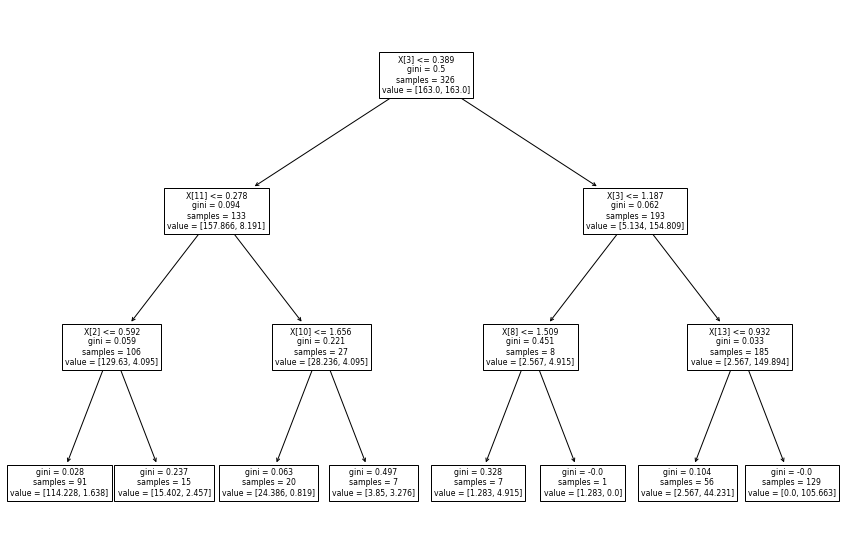

In [324]:
# Include decision tree visualization here
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(voteDT2)

# Discuss what the model has learned

# The model definitely learned because it was able to achieve 80% accuracy on the test set. The first split consistently,
# regardless of hyperparameters was on the third index which is the weight from the right side of the scale. The model 
# wasn't able to reach over 82% accuracy regardless of the parameter tweaking, so maybe the data is just too noisy or there
# isn't enough data.